# Part 1

In [2]:
LABELS = ['aeroplane',  'bicycle', 'bird',  'boat',      'bottle', 
          'bus',        'car',      'cat',  'chair',     'cow',
          'diningtable','dog',    'horse',  'motorbike', 'person',
          'pottedplant','sheep',  'sofa',   'train',   'tvmonitor']

In [3]:
# 

train_image_folder = "/media/vkr/VKR/WorkSpace/Deep Learning Projects/yolov2/data/processed/VOC2012/JPEGImages/"

train_annot_folder = "/media/vkr/VKR/WorkSpace/Deep Learning Projects/yolov2/data/processed/VOC2012/Annotations/"

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import os, cv2
%matplotlib inline

In [6]:
import xml.etree.ElementTree as ET

def parse_annotation(ann_dir, img_dir, labels=[]):
    '''
    output:
    - Each element of the train_image is a dictionary containing the annoation infomation of an image.
    - seen_train_labels is the dictionary containing
            (key, value) = (the object class, the number of objects found in the images)
    '''
    all_imgs = []
    seen_labels = {}
    
    for ann in sorted(os.listdir(ann_dir)):
        if "xml" not in ann:
            continue
        img = {'object':[]}

        tree = ET.parse(ann_dir + ann)
        
        for elem in tree.iter():
            if 'filename' in elem.tag:
                path_to_image = img_dir + elem.text
                img['filename'] = path_to_image
                ## make sure that the image exists:
                if not os.path.exists(path_to_image):
                    assert False, "file does not exist!\n{}".format(path_to_image)
            if 'width' in elem.tag:
                img['width'] = int(elem.text)
            if 'height' in elem.tag:
                img['height'] = int(elem.text)
            if 'object' in elem.tag or 'part' in elem.tag:
                obj = {}
                
                for attr in list(elem):
                    if 'name' in attr.tag:
                        
                        obj['name'] = attr.text
                        
                        if len(labels) > 0 and obj['name'] not in labels:
                            break
                        else:
                            img['object'] += [obj]
                            
                        

                        if obj['name'] in seen_labels:
                            seen_labels[obj['name']] += 1
                        else:
                            seen_labels[obj['name']]  = 1
                        

                            
                    if 'bndbox' in attr.tag:
                        for dim in list(attr):
                            if 'xmin' in dim.tag:
                                obj['xmin'] = int(round(float(dim.text)))
                            if 'ymin' in dim.tag:
                                obj['ymin'] = int(round(float(dim.text)))
                            if 'xmax' in dim.tag:
                                obj['xmax'] = int(round(float(dim.text)))
                            if 'ymax' in dim.tag:
                                obj['ymax'] = int(round(float(dim.text)))

        if len(img['object']) > 0:
            all_imgs += [img]
                        
    return all_imgs, seen_labels

## Parse annotations 
train_image, seen_train_labels = parse_annotation(train_annot_folder,train_image_folder, labels=LABELS)
print("N train = {}".format(len(train_image)))
print("N Labels = {}".format(len(seen_train_labels)))

N train = 22263
N Labels = 20


In [17]:
train_image[:2][1]['object']

[{'name': 'aeroplane', 'xmax': 375, 'xmin': 104, 'ymax': 183, 'ymin': 78},
 {'name': 'aeroplane', 'xmax': 197, 'xmin': 133, 'ymax': 123, 'ymin': 88},
 {'name': 'person', 'xmax': 213, 'xmin': 195, 'ymax': 229, 'ymin': 180},
 {'name': 'person', 'xmax': 44, 'xmin': 26, 'ymax': 238, 'ymin': 189}]

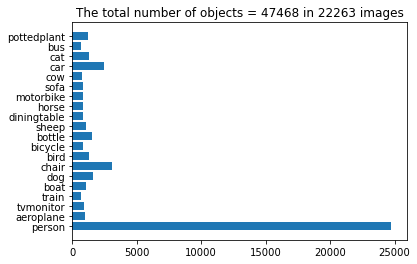

In [18]:
y_pos = np.arange(len(seen_train_labels))

fig = plt.figure()

ax = fig.add_subplot(1,1,1)
ax.barh(y_pos,list(seen_train_labels.values()))
ax.set_yticks(y_pos)
ax.set_yticklabels(list(seen_train_labels.keys()))
ax.set_title("The total number of objects = {} in {} images".format(
    np.sum(list(seen_train_labels.values())),len(train_image)
))

plt.show()

In [19]:
wh = []
for anno in train_image:
    aw = float(anno['width'])  # width of the original image
    ah = float(anno['height']) # height of the original image
    
    for obj in anno["object"]:
        w = (obj["xmax"] - obj["xmin"])/aw # make the width range between [0,GRID_W)
        h = (obj["ymax"] - obj["ymin"])/ah # make the width range between [0,GRID_H)
        temp = [w,h]
        wh.append(temp)
wh = np.array(wh)

print("clustering feature data is ready. shape = (N object, width and height) =  {}".format(wh.shape))

clustering feature data is ready. shape = (N object, width and height) =  (47468, 2)


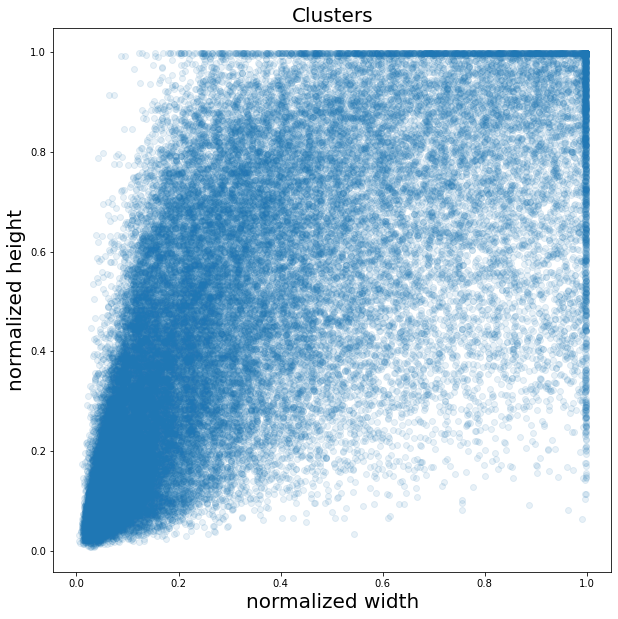

In [20]:
plt.figure(figsize=(10,10))

plt.scatter(wh[:,0],wh[:,1],alpha=0.1)

plt.title("Clusters",fontsize=20)

plt.xlabel("normalized width",fontsize=20)
plt.ylabel("normalized height",fontsize=20)

plt.show()

In [21]:
def iou(box, clusters):
    '''
    :param box:      np.array of shape (2,) containing w and h
    :param clusters: np.array of shape (N cluster, 2) 
    '''
    x = np.minimum(clusters[:, 0], box[0]) 
    y = np.minimum(clusters[:, 1], box[1])

    intersection = x * y
    box_area = box[0] * box[1]
    cluster_area = clusters[:, 0] * clusters[:, 1]

    iou_ = intersection / (box_area + cluster_area - intersection)

    return iou_

In [22]:
def kmeans(boxes, k, dist=np.median,seed=1):
    """
    Calculates k-means clustering with the Intersection over Union (IoU) metric.
    :param boxes: numpy array of shape (r, 2), where r is the number of rows
    :param k: number of clusters
    :param dist: distance function
    :return: numpy array of shape (k, 2)
    """
    rows = boxes.shape[0]

    distances     = np.empty((rows, k)) ## N row x N cluster
    last_clusters = np.zeros((rows,))

    np.random.seed(seed)

    # initialize the cluster centers to be k items
    clusters = boxes[np.random.choice(rows, k, replace=False)]

    while True:
        # Step 1: allocate each item to the closest cluster centers
        for icluster in range(k): # I made change to lars76's code here to make the code faster
            distances[:,icluster] = 1 - iou(clusters[icluster], boxes)

        nearest_clusters = np.argmin(distances, axis=1)

        if (last_clusters == nearest_clusters).all():
            break
            
        # Step 2: calculate the cluster centers as mean (or median) of all the cases in the clusters.
        for cluster in range(k):
            clusters[cluster] = dist(boxes[nearest_clusters == cluster], axis=0)

        last_clusters = nearest_clusters

    return clusters,nearest_clusters,distances

In [23]:
kmax = 11
dist = np.mean
results = {}
for k in range(2,kmax):
    clusters, nearest_clusters, distances = kmeans(wh,k,seed=2,dist=dist)
    WithinClusterMeanDist = np.mean(distances[np.arange(distances.shape[0]),nearest_clusters])
    result = {"clusters":             clusters,
              "nearest_clusters":     nearest_clusters,
              "distances":            distances,
              "WithinClusterMeanDist": WithinClusterMeanDist}
    print("{:2.0f} clusters: mean IoU = {:5.4f}".format(k,1-result["WithinClusterMeanDist"]))
    results[k] = result

 2 clusters: mean IoU = 0.4749
 3 clusters: mean IoU = 0.5482
 4 clusters: mean IoU = 0.5893
 5 clusters: mean IoU = 0.6126
 6 clusters: mean IoU = 0.6345
 7 clusters: mean IoU = 0.6518
 8 clusters: mean IoU = 0.6683
 9 clusters: mean IoU = 0.6797
10 clusters: mean IoU = 0.6924


In [25]:
def plot_cluster_result(plt,clusters,nearest_clusters,WithinClusterSumDist,wh):
    for icluster in np.unique(nearest_clusters):
        pick = nearest_clusters==icluster
        c = current_palette[icluster]
        plt.rc('font', size=8) 
        
        plt.plot(wh[pick,0],wh[pick,1],"p",
                 color=c,
                 alpha=0.5,label="cluster = {}, N = {:6.0f}".format(icluster,np.sum(pick)))
        
        plt.text(clusters[icluster,0],
                 clusters[icluster,1],
                 "c{}".format(icluster),
                 fontsize=20,color="red")
        
        plt.title("Clusters")
        plt.xlabel("width")
        plt.ylabel("height")
    plt.legend(title="Mean IoU = {:5.4f}".format(WithinClusterSumDist))

/media/vkr/VKR/work/anaconda3/envs/Yolo-TF2-VKR/lib/python3.7/site-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  
/media/vkr/VKR/work/anaconda3/envs/Yolo-TF2-VKR/lib/python3.7/site-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  
/media/vkr/VKR/work/anaconda3/envs/Yolo-TF2-VKR/lib/python3.7/site-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  
/media/vkr/VKR/work/anaconda3/envs/Yolo-TF2-VKR/lib/python3.7/site-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprec

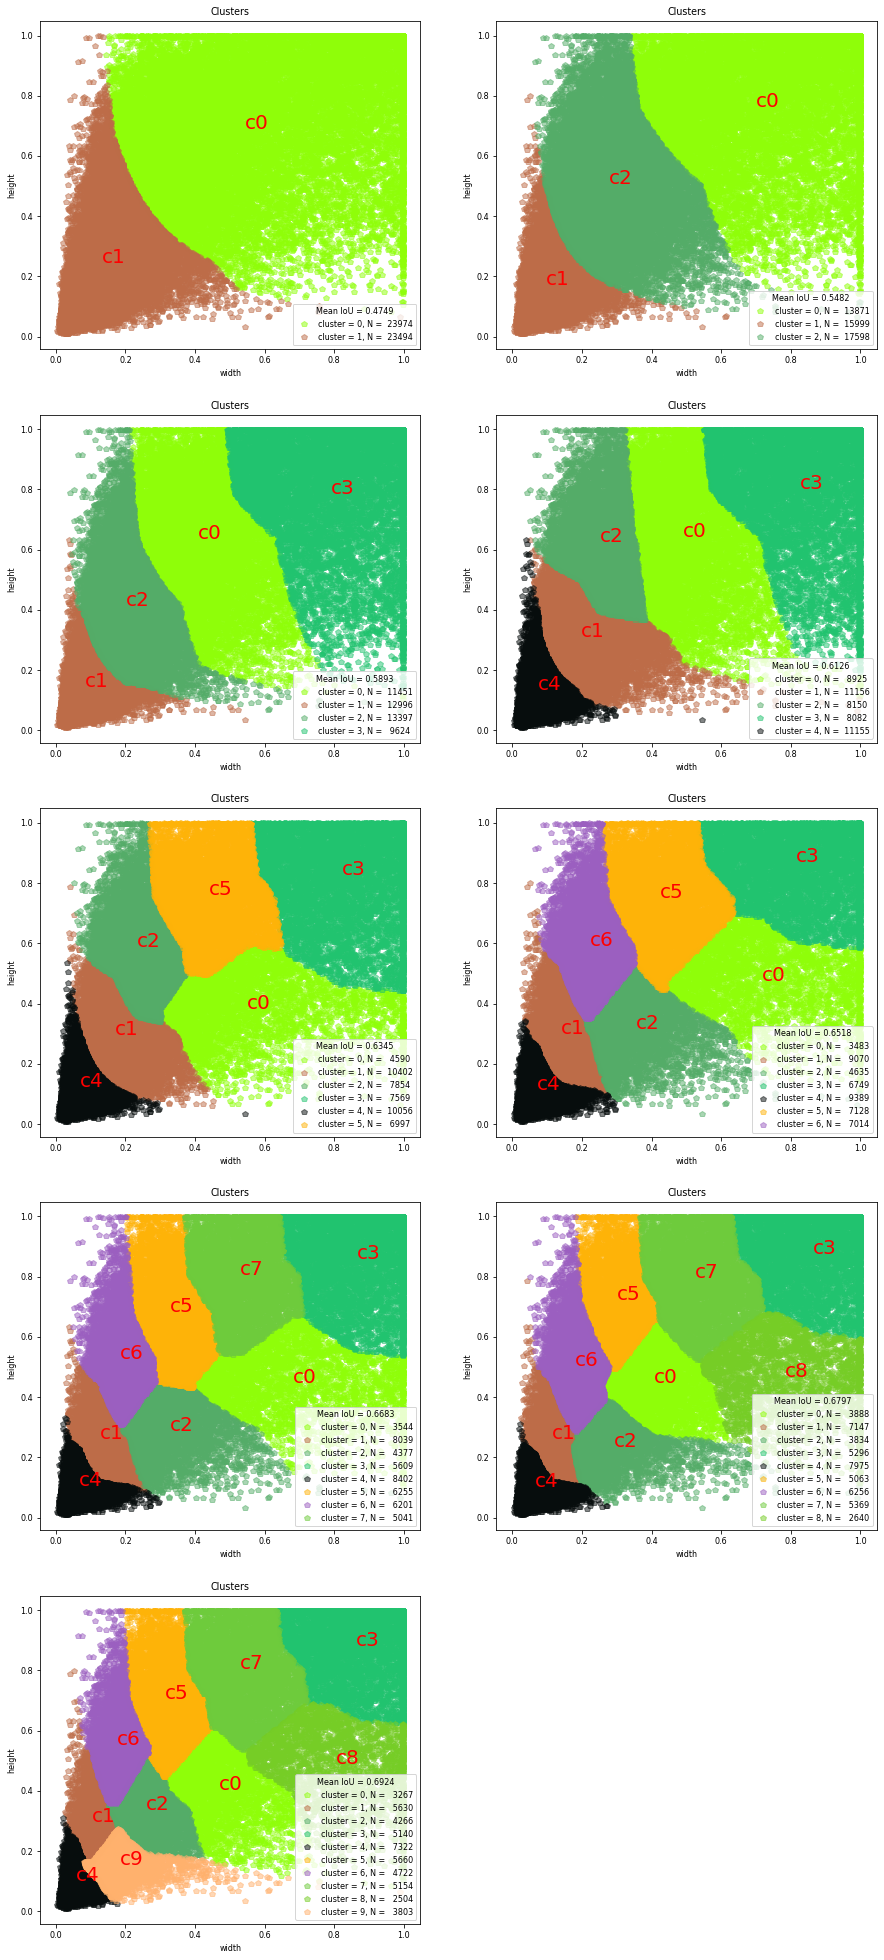

In [26]:
import seaborn as sns
current_palette = list(sns.xkcd_rgb.values())

figsize = (15,35)
count =1 
fig = plt.figure(figsize=figsize)

for k in range(2, kmax):
    result               = results[k]
    clusters             = result["clusters"]
    nearest_clusters     = result["nearest_clusters"]
    WithinClusterSumDist = result["WithinClusterMeanDist"]
    
    ax = fig.add_subplot(kmax/2, 2, count)
    plot_cluster_result(plt, clusters, nearest_clusters, 1 - WithinClusterSumDist, wh)
    count += 1

plt.show()

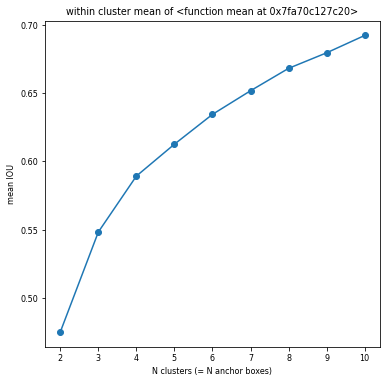

In [27]:
plt.figure(figsize=(6,6))
plt.plot(np.arange(2,kmax),
         [1 - results[k]["WithinClusterMeanDist"] for k in range(2,kmax)],"o-")
plt.title("within cluster mean of {}".format(dist))
plt.ylabel("mean IOU")
plt.xlabel("N clusters (= N anchor boxes)")
plt.show()

In [28]:
Nanchor_box = 4
results[Nanchor_box]["clusters"]

array([[0.40969899, 0.6348552 ],
       [0.08448373, 0.14515983],
       [0.20274386, 0.41333432],
       [0.79143977, 0.78468881]])